# Use Case Description

Move beyond traditional threat modeling to an AI-powered attack modeling system that ingests real-world artifacts like architecture diagrams, Swagger/OpenAPI docs, Postman Collections, and network topologies to automatically generate potential attack scenarios. These scenarios go beyond high-level threats, mapping out concrete abuse/test cases that security engineers and QA teams can simulate, test, or harden against.

## Model used for this use case
Reasoning Model is well-suited for this use case because the task is complex and requires deep reasoning.

## SetUp

The setup scripts below are essentially the same as those in the [Quickstart (Reasoning Model)](https://github.com/RobustIntelligence/foundation-ai-cookbook/blob/main/1_quickstarts/Preview_Quickstart_reasoning_model.ipynb)

### Notice
- The code below assumes that users have access to the models via Hugging Face. If you are using API access instead, please replace the inference code with the API version provided in the Quickstart guide.
- This model is currently in preview mode and may receive updates. As a result, outputs can vary even when parameters are configured to ensure reproducibility.

In [1]:
import os
import transformers
import torch
from IPython.display import display, Markdown

HF_TOKEN = os.getenv("HF_TOKEN")

def _get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

DEVICE = _get_device()

In [2]:
MODEL_ID = "" # To be relaced with the final model name

from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=MODEL_ID,
    device_map="auto",
    torch_dtype=torch.float32, # this model's tensor_type is float32
    token=HF_TOKEN,
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
generation_args = {
    "max_new_tokens": 1024,
    "temperature": None,
    "repetition_penalty": 1.2,
    "do_sample": False,
    "use_cache": True,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
}

In [4]:
import re

def inference(prompt):
    messages = [
        {"role": "user", "content": prompt},
    ]
    inputs = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # The old model version didn’t include the <think> token in the chat template.
    think_token = "<think>\n"
    if not inputs.endswith(think_token):
        inputs += think_token
    
    inputs = tokenizer(inputs, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **generation_args,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens = False)

    # extract the thinking part only
    match = re.search(r"<think>(.*?)<\|end_of_text\|>", response, re.DOTALL)
    
    return match.group(1).strip()

## Attack Modelling / Red-team Planning

We will have the model to analyze architecture description and find some potential security risks and vulnerabilities.

In [5]:
def make_prompt(architecture_description):
    return f"""
    # Security Architecture Analysis Request

    ## Architecture Overview
    {architecture_description}

    ## Analysis Instructions

    I'm performing a security architecture review of the system described above to support a penetration testing engagement. Please help me identify meaningful and impactful security risks by analyzing:

    1. **Trust Boundaries**: Identify key trust boundaries and potential vulnerabilities at these transition points

    2. **Data Flow Risks**: Analyze the data flows between components and identify potential security weaknesses

    3. **Component-Specific Vulnerabilities**: Focus on the most critical/high-risk vulnerabilities specific to each component type (not generic listings)

    4. **Authentication & Authorization Flows**: Evaluate potential weaknesses in how authentication/authorization is handled across the architecture

    5. **Inter-Component Communications**: Identify risks in how components communicate with each other

    For each identified vulnerability:
    - Provide a clear, concise name that reflects the specific architectural context
    - Briefly explain why it's a concern in this specific architecture
    - Focus on architectural issues rather than implementation bugs
    - Prioritize concerns that span component boundaries or involve interaction between systems

    Avoid generic vulnerability listings. Instead, focus on issues specific to this architecture's design, component interactions, and trust boundaries.
    """

The below image is the application architecture. Due to this model not having multi-modal capabilities, we are going to get a description of this image using another LLM.

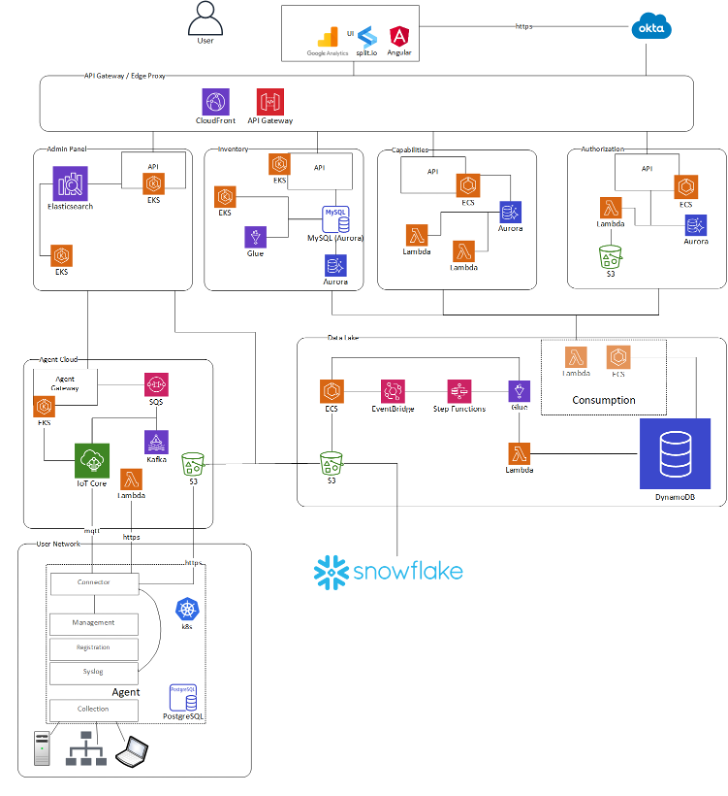

In [6]:
example_architecture_description = """
# Cloud-Native Architecture with Trust Boundaries

## User Access Layer
- User interacts with Angular frontend hosted on CloudFront
- Authentication occurs via Okta
- Google Analytics, Split.io integrated in frontend
- User → [TRUST BOUNDARY] → CloudFront → API Gateway

## API Management Layer
- CloudFront serves as CDN for frontend applications
- API Gateway handles all external API requests
- [TRUST BOUNDARY] between external users and internal services

## Microservice Domains (4 separate service clusters)
1. Admin Panel:
   - ElasticSearch for data indexing
   - EKS cluster for containerized services
   - Lambda functions for processing
   - Data flows: EKS ↔ ElasticSearch

2. Inventory Service:
   - ECS containers
   - EKS cluster
   - Glue ETL processes
   - MySQL Aurora database
   - Data flows: EKS → Aurora, Glue → Aurora

3. Capabilities Service:
   - ECS containers
   - Lambda functions
   - Aurora databases
   - Data flows: Lambda ⟷ Aurora, ECS ⟷ Aurora

4. Authorization Service:
   - Lambda functions
   - ECS containers
   - Aurora database
   - S3 storage
   - Data flows: Lambda → S3, Lambda ⟷ Aurora

## Agent Cloud Layer
- Agent Gateway (EKS)
- SQS for message queuing
- IoT Core for device communications
- Kafka for event streaming
- S3 for data storage
- Lambda functions for processing
- [TRUST BOUNDARY] between cloud and agent networks
- Data flows: Agent Gateway → IoT Core → Lambda → Kafka → SQS

## User Network / Edge Agents
- Agent software with multiple components:
  - Connection management
  - System management
  - Registration services
  - Syslog handling
  - Collection services
- Local PostgreSQL database
- [TRUST BOUNDARY] between user network and agent cloud
- Data flows: Agent components ⟷ PostgreSQL, Agent → HTTPS → Agent Cloud

## Data Lake
- S3 as central data repository
- EventBridge for event routing
- Step Functions for workflow orchestration
- Glue for ETL processing
- Lambda for data processing
- Data flows: ECS → S3, ECS → EventBridge → Step Functions → Glue → Lambda → DynamoDB
- S3 ↔ Snowflake (bidirectional data exchange)

## Data Consumption
- DynamoDB for application data access
- Lambda functions for data processing
- ECS containers for service access
- Data flows: Lambda ⟷ DynamoDB
"""

In [7]:
response = inference(make_prompt(example_architecture_description))
display(Markdown(response))

### 1. Trust Boundaries

**Vulnerability Name:** Inadequate Segmentation of Trust Boundaries

**Explanation:** The architecture has several trust boundary transitions where untrusted inputs from one layer might not be properly sanitized before entering another. For example, the API Gateway acts as a trust boundary between external users and internal microservices. If there isn't proper validation here, an attacker could inject malicious payloads through APIs.

*Impact:* An exploit would allow unauthorized access to sensitive resources within the internal network. Since AWS services are often configured using IAM roles, misconfigured permissions could lead to privilege escalation if the trust relationships aren't correctly set up.

**Mitigation:** Ensure strict input validation at every trust boundary. Use tools like OWASP ModSecurity Core Rule Set (CRS) or AWS WAF to filter incoming traffic. Properly configure IAM policies ensuring least privilege principles are applied consistently across all services interacting over trust boundaries.

---

### 2. Data Flow Risks

**Vulnerability Name:** Excessive Data Exposure Through Unsecured Channels

**Explanation:** While data flows are outlined, some channels may lack encryption. For instance, communication between the User Network/Edge Agents and the Agent Cloud uses HTTPS but doesn’t specify TLS version or cipher suites. Older versions can be vulnerable to attacks.

*Impact:* Intercepting or manipulating data during transit could expose sensitive information. Even if encrypted, weak ciphers or outdated protocols (like SSLv3) could still compromise confidentiality/integrity.

**Mitigation:** Enforce strong encryption standards (e.g., TLS 1.2/1.3) across all data transmission paths. Regularly audit cryptographic configurations and use services like AWS Certificate Manager for secure connections.

---

### 3. Component-Specific Vulnerabilities

#### Admin Panel – Elasticsearch

**Vulnerability Name:** Misconfigured Elasticsearch Cluster Permissions

**Explanation:** Elasticsearch requires careful configuration of indices and role mappings. If default settings are used without adjusting privileges, attackers could enumerate or access unintended data via exposed endpoints.

*Impact:* Unauthorized read/write access to indexed data, potentially leading to data breaches or tampering.

**Mitigation:** Implement proper index-level access control, restrict exposure of Elasticsearch to only necessary hosts/networks, and utilize Kibana’s built-in security features.

---

#### Authorization Service – Lambda → S3

**Vulnerability Name:** Insecure Direct Object References (IDOR) in S3 Buckets

**Explanation:** Lambdas writing to S3 buckets might inadvertently grant public access due to incorrect bucket/policy configurations. Without proper checks, authenticated lambda functions might upload files accessible to anyone.

*Impact:* Unauthorized download/upload of sensitive data stored in S3.

**Mitigation:** Utilize Amazon S3 Bucket Policies and CORS settings carefully. Ensure that lambdas have minimal required permissions and that objects are served privately unless explicitly made public.

---

### 4. Authentication & Authorization Flows

**Vulnerability Name:** Weaknesses in OAuth/OpenID Connect Implementation

**Explanation:** Okta provides identity federation, but if the integration isn't done according to best practices, token lifetimes, scopes, or state parameters might be mishandled. Also, client-side apps (Angular) must securely store tokens; improper storage (e.g., localStorage instead of sessionStorage) increases risk.

*Impact:* Token theft could result in account takeovers. Additionally, inadequate authorization checks in backend services could bypass protection mechanisms.

**Mitigation:** Validate tokens thoroughly, check audience/issuer claims, enforce short-lived tokens, and ensure proper authorization checks against validated tokens. Store tokens securely and avoid exposing them in browser storage when possible.

---

### 5. Inter-Component Communications

**Vulnerability Name:** Insufficient Message Queuing Security (SQS)

**Explanation:** Messages sent via SQS between Lambda functions and agents might not be encrypted in transit or signed/authenticated. Moreover, dead-letter queues should exist to handle failed messages, which otherwise could cause undetected failures or leaks.

*Impact:* Compromised integrity or confidentiality of queued messages, leading to data leakage or manipulation.

**Mitigation:** Enable server-side encryption for SQS, sign/encrypt messages if needed, and implement proper error handling with DLQs. Monitor queue activity regularly for anomalies.

---

Each of these findings represents areas where architectural decisions introduce potential security risks. Addressing these will require detailed analysis and remediation steps tailored to the specific implementations and configurations in place.